# Classical AB Testing

In [1]:
#Importing Libraries
import numpy as np
import scipy.stats as stats 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import IPython

In [2]:
#Configuring Notebook settings
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('max_column', None)

## Data Loading and Preparation 

In [3]:
#Importing the collected Data
file_name = '../data/AdSmartABdata.csv'
collected_data = pd.read_csv(file_name)

## Separating the Answered Users

In [4]:
#Users who either answered yes or no
answered_df = collected_data.copy(deep=True)
answered_df = answered_df[answered_df['yes'] == 1].append(answered_df[answered_df['no'] == 1])


In [5]:
# Identifying the control group
control_df = answered_df[answered_df['experiment'] == 'control']

In [6]:
# Identifying the exposed group
exposed_df = answered_df[answered_df['experiment'] == 'exposed']

In [7]:
# Forming a combined DataFrame substituting the yes and no column to response and having only 1 and 0 as values where 1 translates to a yes and 0 to no
#All users who answered yes
all_yes_df = control_df[control_df['yes'] == 1].append(exposed_df[exposed_df['yes'] == 1])
all_yes_df = all_yes_df.drop(['yes','no'], axis = 1)
all_yes_df['response'] = 1
#All users who answered no
all_no_df = control_df[control_df['no'] == 1].append(exposed_df[exposed_df['no'] == 1])
all_no_df = all_no_df.drop(['yes','no'], axis = 1)
all_no_df['response'] = 0
#Final Combined dataframe will be
combined_df = all_yes_df.append(all_no_df)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,5b3dd0c2-8faf-4f92-b704-b6e44b307149,exposed,2020-07-04,23,Generic Smartphone,6,Chrome Mobile,1
1,78a601bc-d74c-43fe-b193-885eaa9b2149,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1
2,a6bebacb-e756-4bd9-be43-15cf04e79dbb,control,2020-07-04,8,Generic Smartphone,6,Chrome Mobile,1
3,2a0fd940-3857-4618-be52-d215c54931e4,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1
4,5e7c9d3b-1a50-48dc-9792-508acb0020bc,control,2020-07-10,14,Generic Smartphone,6,Chrome Mobile,0


## Testing

### Defining our Experiment

#### Hypothesis

Null Hypothesis: Users who saw the new Ad created by SmartAd dont show no difference in responding to the BIO to the once who saw a static Ad
HypothesisL Users who saw the new Ad created by SmartAd respond to the BIO quesionare better than users who saw a static Ad

Given that we don’t know if the new design will perform better or worse (or the same?) as our current design, we choose a two-tailed test:
- Hₒ: p = pₒ
- Hₐ: p ≠ pₒ
where p and pₒ stand for the conversion rate of the new and old design, respectively. 
We set a confidence level of 95%(1 — α):
- α = 0.05

#### Variables

Independent Variables:
- A control group - They'll be shown the old design
- A exposed group - They'll be shown the new design

Dependent Variable:
- Response:
  - 0, indicating the user choose No
  - 1, indicating the user choose Yes

#### Chossing Sample size

- We can't choose our own sample because we are already given a sample.
- We set our Statistical Power = 0.8 or 80% thus B(Beta) = 0.2 or 20%

#### Data Preparation

- Data is already combined and prepared as seen in the beginning of the file

In [8]:
# Check Null Values
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1243 non-null   object
 1   experiment   1243 non-null   object
 2   date         1243 non-null   object
 3   hour         1243 non-null   int64 
 4   device_make  1243 non-null   object
 5   platform_os  1243 non-null   int64 
 6   browser      1243 non-null   object
 7   response     1243 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 77.8+ KB


In [9]:
# Check Repeted user responses
number_of_users = combined_df.auction_id.unique()
# Number of users must be equal to row size of the collected data
print(f'The data has {combined_df.shape[0] - len(number_of_users)} repeated users.')

The data has 0 repeated users.


### Identifying Conversion Rates

In [10]:
# Grouping the dataframe by experiment column and then get response
conversion_rates = combined_df.groupby('experiment')['response']

#defining methods to generate the standard deviation and standard error of mean
std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)


conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
print(pd.DataFrame(conversion_rates))

            conversion_rate  std_deviation  std_error
experiment                                           
control               0.451          0.498      0.021
exposed               0.469          0.499      0.019


The Ads performed similary, with our new SmartAd performing slightly better. We have 45.1% on our control group while we have 46.9% on our exposed group.

#### Plotting the controlled vs treatment group response

Text(0, 0.5, 'Response (Proportion)')

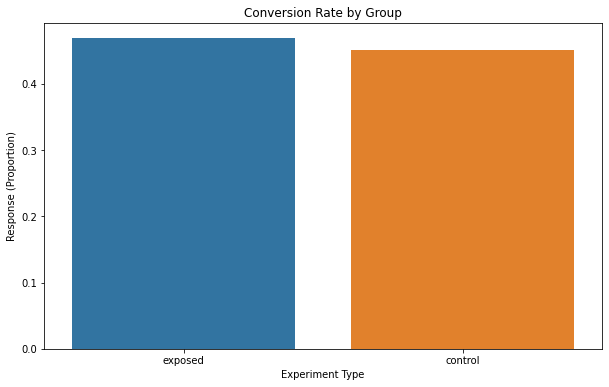

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(x=combined_df['experiment'], y=combined_df['response'], ci=False)
plt.title('Conversion Rate by Group')
plt.xlabel('Experiment Type')
plt.ylabel('Response (Proportion)')

### Testing the Hypothesis

In [12]:
#Defining the control group results
control_results = combined_df[combined_df['experiment'] == 'control']['response']
#Defining the exposed group results
exposed_results = combined_df[combined_df['experiment'] == 'exposed']['response']

In [13]:
#Identifying counts, success and nob list
n_con = control_results.count()
n_treat = exposed_results.count()
successes = [control_results.sum(), exposed_results.sum()]
nobs = [n_con, n_treat]

In [14]:
#Running a z-test
z_stat, pval = proportions_ztest(successes, nobs=nobs)
#Getting the lower and upper bounds
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.5)

In [15]:
#Printing calculated results
print(f'z-statistic: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.2%},{upper_con:.2%}]')
print(f'ci 95% for treatment group: [{lower_treat:.2%},{upper_treat:.2%}]')

z-statistic: -0.646
p-value: 0.518
ci 95% for control group: [43.66%,46.44%]
ci 95% for treatment group: [45.57%,48.19%]


### Conclusion

Since our p-value=0.518 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different or better than our old one.